<a href="https://colab.research.google.com/github/michelleaeh/Dissertation/blob/master/2MyoASL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


**The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.**

**Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.**

**The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL**

**If you use this dataset please cite the following papers:**

**@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}**

**@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}**

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd

from google.colab import files
from mpl_toolkits import mplot3d
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from zipfile import ZipFile

# Import zip containing all files
file_name = "/content/2MyoASL.zip"

# Extract all files from zip
with ZipFile(file_name, 'r') as zip:
  zip.extractall()

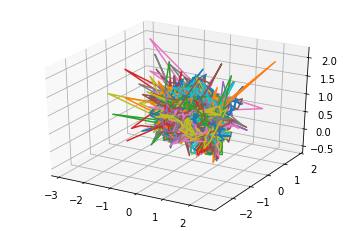

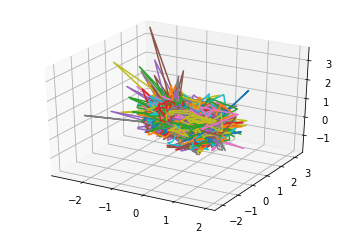

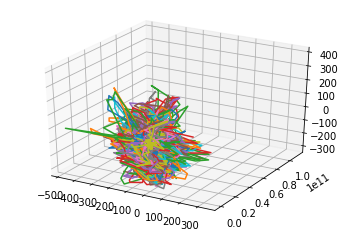

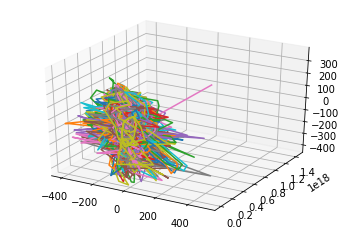

In [2]:
### Combine all files
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']
lengths=np.zeros(849)
reps=np.zeros(36)
wordnum=-1
counter=0

for w in words:
  repcount=0
  wordnum+=1

  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'

    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      lengths[counter-1]=len(trial)
      
      # Replace counter with evaluated term
      for r in range(0,len(trial)):
        trial.iloc[r,0]=wordnum
        
      # Combine all trials
      if path=='/content/2MyoASL/allmorning_10.csv':
          matrix=trial
          
          # Create plot for EMG

          # Create plot for accelerometer
          plt.figure()
          alx=plt.axes(projection='3d')
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          
          plt.figure()
          arx=plt.axes(projection='3d')
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          
          # Create plot for gyroscope
          plt.figure()
          glx=plt.axes(projection='3d')
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          
          plt.figure()
          grx=plt.axes(projection='3d')
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          
      else:
          matrix=pd.concat([matrix, trial])

          ###############################################
          # Create plot for accelerometer
          alx.plot3D(trial.loc[:, 'AXL'].values, trial.loc[:, 'AYL'].values, trial.loc[:, 'AZL'].values)
          arx.plot3D(trial.loc[:, 'AXR'].values, trial.loc[:, 'AYR'].values, trial.loc[:, 'AZR'].values)
          #plt.show()

          # Create plot for gyroscope
          glx.plot3D(trial.loc[:, 'GXL'].values, trial.loc[:, 'GYL'].values, trial.loc[:, 'GZL'].values)
          grx.plot3D(trial.loc[:, 'GXR'].values, trial.loc[:, 'GYR'].values, trial.loc[:, 'GZR'].values)
          ###############################################

  reps[wordnum]=repcount
plt.show()
          

In [3]:
# Generate matrices for all combinations of sensors (E=3, A=5, G=7, O=11)
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155]
comb=['e', 'a', 'g', 'o', 'ea', 'eg', 'eo', 'ag', 'ao', 'go', 'eag', 'eao', 'ego', 'ago', 'eago']
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
    'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
n=0

# Eliminate innecessary columns to create combinatory matrices
for v in products:
  m=matrix
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  products[n]=m
  exec(comb[n]+"=products[n]")
  n+=1
  
  # Normalize and Standardize each of the 15 matrices
  # Separate features from target values
  x = m.loc[:, m.columns != 'Counter'].values   # Features
  y = m.loc[:,['Counter']].values               # Target

  ## Normalize features so that each column is between 0 and 1
  norm_matrix=(m-m.min())/(m.max()-m.min())
  exec("norm_matrix_"+comb[n-1]+"=pd.DataFrame(norm_matrix)")

  # Normalize features
  normalized_matrix=(x-x.min())/(x.max()-x.min())
  exec("normalized_matrix_"+comb[n-1]+"=pd.DataFrame(normalized_matrix)")

  # Standardize features with mean=0 and deviation=1
  standardized_matrix=StandardScaler().fit_transform(x)
  exec("standardized_matrix_"+comb[n-1]+"=pd.DataFrame(standardized_matrix)")

  # Save data frames as csv files
  #matrix.to_csv(path_or_buf='/content/matrix_'+comb[n-1]+'.csv')
  exec("norm_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normmatrix_'+comb[n-1]+'.csv')")
  exec("normalized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/normalizedmatrix_'+comb[n-1]+'.csv')")
  exec("standardized_matrix_"+comb[n-1]+".to_csv(path_or_buf='/content/standardizedmatrix_'+comb[n-1]+'.csv')")

In [4]:
# Plot EMG, accelerometer, gyroscope and orientation
        #%matplotlib inline
        #fig = plt.figure()
        #ax = plt.axes(projection='3d')
        
        # Data for a three-dimensional line
        #zline = np.linspace(0, 15, 1000)
        #xline = np.sin(zline)
        #yline = np.cos(zline)
        #ax.plot3D(xline, yline, zline, 'gray')

        # Data for three-dimensional scattered points
        #zdata = 15 * np.random.random(100)
        #xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
        #ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
        #ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');

Normalized matrix
[0.23128872 0.18843268 0.14434638 0.10150933 0.08370594 0.03602182
 0.0267899  0.02313825 0.02247211 0.01468574 0.01245734 0.01122126
 0.00957529 0.00945351 0.00877457 0.00769596 0.0074402  0.00664727
 0.00604279 0.00567035 0.00527104 0.00484373 0.00402027 0.00397073
 0.00377051 0.00350758 0.00312599 0.00306406 0.00246604 0.00228341
 0.00185457 0.00149379 0.00133003 0.00091457 0.00071427]
[59.97163126 54.13108625 47.37743812 39.73027849 36.07835778 23.66745098
 20.41052589 18.96853753 18.69349664 15.11181198 13.91814108 13.20959122
 12.20238444 12.12453538 11.68104101 10.93956781 10.75625141 10.16694207
  9.69364827  9.39017598  9.0535064   8.67877587  7.90672244  7.85784921
  7.65717341  7.38537554  6.97207819  6.90266902  6.19254301  5.95883002
  5.37020225  4.81961906  4.54777838  3.77118719  3.33272543]


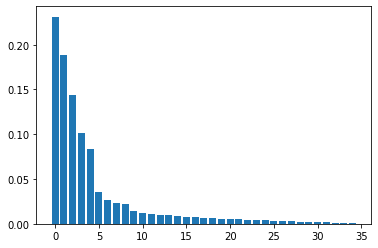

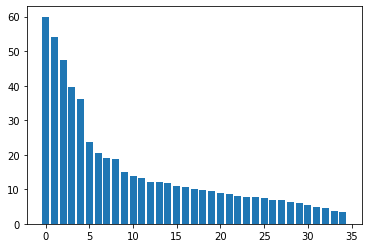

Normalized features
[1.00000000e+00 1.08119639e-14 4.98187556e-30 1.79892591e-30
 1.62089726e-30 1.56777130e-30 8.69438956e-31 7.86677644e-31
 7.23501694e-31 4.31057012e-31 4.05930659e-31 2.57775916e-31
 2.18634427e-31 1.66429347e-31 1.57094534e-31 1.32439912e-31
 1.18690552e-31 1.18529907e-31 1.05872939e-31 9.30655176e-32
 8.72538048e-32 8.63168275e-32 6.45551166e-32 5.68120483e-32
 5.38321475e-32 4.00881172e-32 3.25734104e-32 2.31737189e-32
 9.98401513e-33 9.98401513e-33 9.98401513e-33 9.98401513e-33
 7.16176162e-34 5.10057165e-35]
[5.28976555e+00 5.50032964e-07 1.18068178e-14 7.09484745e-15
 6.73463661e-15 6.62335112e-15 4.93237368e-15 4.69174962e-15
 4.49941653e-15 3.47299198e-15 3.37025181e-15 2.68570058e-15
 2.47340764e-15 2.15799969e-15 2.09660666e-15 1.92506707e-15
 1.82240332e-15 1.82116961e-15 1.72119038e-15 1.61372981e-15
 1.56253089e-15 1.55411860e-15 1.34400771e-15 1.26083033e-15
 1.22731849e-15 1.05911777e-15 9.54702455e-16 8.05256596e-16
 5.28553605e-16 5.28553605e-16 5.

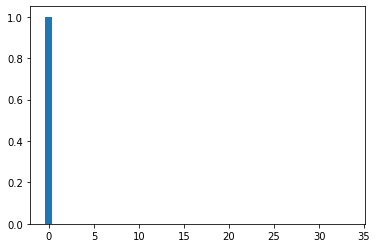

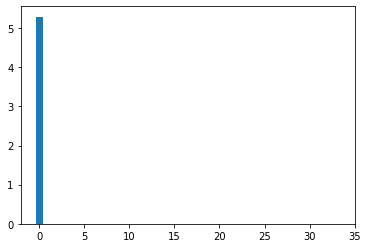

Standardized features
[0.08954424 0.06813366 0.0655316  0.06200033 0.05404295 0.04103381
 0.0395162  0.03923041 0.03897126 0.03775099 0.03528391 0.03217488
 0.03106451 0.03020289 0.02809329 0.02678967 0.025944   0.02495061
 0.02401614 0.02378126 0.02355548 0.02326915 0.02207918 0.01785485
 0.01672083 0.01582244 0.01575534 0.01521609 0.01150892 0.01091833
 0.00501292 0.0017679  0.00153612 0.00092583]
[360.36132373 314.34040944 308.27955943 299.85849488 279.95540077
 243.94405487 239.3905056  238.5232694  237.734158   233.98255844
 226.20785712 216.01197262 212.25188988 209.28765295 201.84622201
 197.10744364 193.97143996 190.22165688 186.62548667 185.71064698
 184.8269784  183.70017942 178.94140582 160.91533815 155.72137354
 151.48028842 151.15874021 148.54936993 129.19232548 125.83382458
  85.26384396  50.63468317  47.19885255  36.64247058]


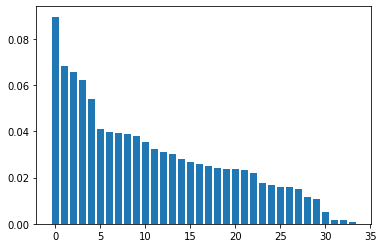

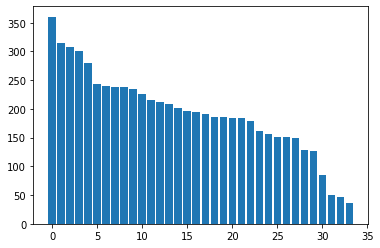

In [5]:
fn=np.arange(35)

# PCA for normmatrix
pca = PCA(n_components=35)
pca.fit(norm_matrix)
print("Normalized matrix")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn,pca.explained_variance_ratio_)
plt.show()
plt.bar(fn,pca.singular_values_)
plt.show()

# PCA for normalizedmatrix
pca = PCA(n_components=34)
pca.fit(normalized_matrix)
print("Normalized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()

# PCA for standardizedmatrix
pca = PCA(n_components=34)
pca.fit(standardized_matrix)
print("Standardized features")
print(pca.explained_variance_ratio_)
print(pca.singular_values_)
plt.figure()
plt.bar(fn[0:34],pca.explained_variance_ratio_)
plt.show()
plt.bar(fn[0:34],pca.singular_values_)
plt.show()

In [6]:
print(reps.T)

#for n in range(len(words)):
#  for l in range(reps[n]):


[19. 24. 32. 20. 24. 20. 19. 31. 24. 29. 20. 21. 23. 33. 34. 18. 27. 24.
 35. 19. 17. 34. 30. 19. 22. 21. 23. 27. 27.  4. 20. 19. 20. 20. 21. 29.]


TODO:

check what happens when combining diff data sources

graph components

find correlations

interpret pca results

try pca per individual/word

-read dataset papers



https://www.researchgate.net/publication/303707429_Combining_Smartphone_and_Smartwatch_Sensor_Data_in_Activity_Recognition_Approaches_an_Experimental_Evaluation

References

https://stackoverflow.com/questions/56449262/how-to-upload-folders-to-google-colab

https://github.com/datarail/datarail/issues/39

https://dbader.org/blog/python-check-if-file-exists

https://datacarpentry.org/python-socialsci/11-joins/index.html

https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html

https://www.tutorialspoint.com/matplotlib/matplotlib_bar_plot.htm
